## **PPDB로 충돌확률계산**</br>
1. 48시간 이내의 conjunction pair만 추출
2. celestrak, PPDB에 중복 pair만 추출
3. celestrak과 상관관계 분석

## **import**

In [3]:
from sgp4.api import Satrec, jday
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, TEME
from datetime import timedelta, datetime
import pandas as pd
import requests
import json
import configparser
from tqdm import tqdm
from math import sqrt
import json
import requests
import configparser
import time
from math import exp

## **function**

In [28]:
def str_to_datetime(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')

# space-track에서 object type만 가져옴.
def get_object_type(requestFindObjects):
 
    r_f_d =f'/class/gp/NORAD_CAT_ID/{str(requestFindObjects)}/orderby/CCSDS_OMM_VERS%20asc/'
    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit
        uriBase = "https://www.space-track.org"
        requestLogin = "/ajaxauth/login"
        requestCmdAction = "/basicspacedata/query"
        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uriBase + requestLogin, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uriBase + requestCmdAction + r_f_d)

        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        result = {}

    # Extract 'NORAD_CAT_ID' and 'OBJECT_TYPE' from the data and add it to the result dictionary
        for item in tqdm(data):
            norad_cat_id = item['NORAD_CAT_ID']
            object_type = item['OBJECT_TYPE']
            result[norad_cat_id] = object_type

        session.close()
        

    return result 

# 위성의 몸체를 둘러싸는 직사각형을 가정. 직육면체의 대각선=radius 가정.
def calculate_radius(my_dic):
    radius=0
    # 1 , 9, 21, 30 
    if my_dic['shape'] == 'Cyl' \
        or my_dic['shape'] == 'Cyl + 1 Nozzle'\
        or my_dic['shape']== 'Oct Cyl'\
        or my_dic['shape']== 'Hex Cyl':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            height = my_dic['height']
            diameter = my_dic['diameter']  
            radius = sqrt(diameter**2+height**2)/2
            
        else:
            radius = 1.5
    
    # 2, 3, 12, 13 , 19, 20, 22, 23, 26, 8, 14, 15, 16, 25, 29, 11 ,17
    elif my_dic['shape'] == 'Box + 1 Pan' \
        or my_dic['shape']== 'Box + 2 Pan' \
        or my_dic['shape']== 'Box + 2 Ant' \
        or my_dic['shape']== 'Box + 3 Pan' \
        or my_dic['shape']== 'Box + 4 Pan'\
        or my_dic['shape']== 'Box + 2 Pan + 1 Dish' \
        or my_dic['shape']== 'Box + 2 Pan + 1 Ant'\
        or my_dic['shape']== 'Hex Cyl + 2 Pan + 1 Dish'\
        or my_dic['shape']== 'Box + 1 Pan + 1 Ant'\
        or my_dic['shape']== 'Half Cone + 1 Rod'\
        or my_dic['shape'] == 'Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 3 Pan'\
        or my_dic['shape'] == 'Half Hex Cyl + 2 Pan' \
        or my_dic['shape'] == 'Cyl + 4 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 1 Pan'\
        or my_dic['shape'] == 'Trap Cyl + 2 Pan'\
        or my_dic['shape'] == 'Box + 1 Sail'  :
        if my_dic['height'] != None and my_dic['span'] != None:       
            
            span = my_dic['span']
            height = my_dic['height']
            radius = sqrt(span**2+height**2)/2
            
        else:
            radius = 1.5
        

    #4
    elif my_dic['shape'] == 'Box' :
        if my_dic['height'] != None and my_dic['width'] != None and my_dic['depth'] != None:
            depth = my_dic['depth']
            width = my_dic['width']
            x = max(width,depth)
            height = my_dic['height']
            radius = sqrt(x**2+height**2)/2
               
        else:
            radius = 1.5
    #5
    elif my_dic['shape'] == 'Sphere':
        max_dimension = 0
        if my_dic['diameter'] != None:
            radius = max(max_dimension,my_dic['diameter']/2)
        if my_dic['depth'] == None and my_dic['height'] == None and my_dic['width'] == None:            
            radius = 1.5
        else: 
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = max(max_dimension, max(my_dic['depth'],my_dic['width'],my_dic['height']))
        
          
    #6
    elif my_dic['shape'] == 'Cone':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = sqrt(diameter**2+height**2)/2
        elif my_dic['depth'] != None and my_dic['height'] != None and my_dic['width'] == None:
            depth = my_dic['depth']
            width = my_dic['width']
            x = max(width,depth)
            height = my_dic['height']
            radius = sqrt(x**2+height**2)/2
        else:
            
            radius = 1.5
         
    #7, 10, 
    elif my_dic['shape'] == 'Sphere + Cyl' \
        or my_dic['shape'] == 'Cyl + Cone'    :
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = sqrt(diameter**2+height**2)/2
        elif my_dic['diameter'] != None and my_dic['span'] != None :
            diameter = my_dic['diameter']
            span = my_dic['span']
            radius = sqrt(diameter**2+span**2)/2
        else:
            
            radius = 1.5
         
    # 28 
    elif my_dic['shape'] == 'Cyl + 1 Ant':
        if  my_dic['diameter'] != None and my_dic['span'] != None:   
            diameter = my_dic['diameter']
            span = my_dic['span'] 
            radius = sqrt(diameter**2+span**2)/2
        else:
            radius = 1.5
         

    # 18, 27 
    elif my_dic['shape'] == 'Box + 1 Ant'\
        or my_dic['shape'] == 'Box + 1 Rod':
        if  my_dic['width'] != None and my_dic['depth'] != None  and my_dic['span'] != None:   
            width = my_dic['width']
            depth = my_dic['depth']
            x = max(width,depth)
            span = my_dic['span'] 
            radius = sqrt(x**2+span**2)/2
        else:
            radius = 1.5
         
    else:
        radius=1.5

    return round(radius/1000,6)

# **Preprocessing**


## **48시간 이내의 pair만 추출**

In [21]:
ppdb_pair = pd.read_excel("./input_data/PPDB_CA_10m24d08h.xlsx")
celestrak_pair = pd.read_csv("./input_data/Celestrak_CA_10m24d08h.csv")
print('초기 PPDB pair 수:',len(ppdb_pair))
print('초기 CELESTRAK pair 수:', len(celestrak_pair))

# celestrak 데이터를 48시간 이내로 필터링
celestrak_pair = celestrak_pair[(celestrak_pair['TCA']>='2023-10-24 08:00') & (celestrak_pair['TCA']<='2023-10-26 08:00')]
print('48시간 이내 Celestrak의 pair 개수 : ',len(celestrak_pair))

초기 PPDB pair 수: 254389
초기 CELESTRAK pair 수: 68387
48시간 이내 Celestrak의 pair 개수 :  19439


## **celestrak, PPDB에 둘다 존재하는 pair만 추출**

In [61]:
duplicated_pair_df  = pd.DataFrame(columns=['PRIMARY','SECONDARY','DCA','TCA','Celestrak_index'])

for i in tqdm((list(celestrak_pair.index))):
      primary_id = celestrak_pair['NORAD_CAT_ID_1'][i]
      secondary_id = celestrak_pair['NORAD_CAT_ID_2'][i]
      tca = str_to_datetime(celestrak_pair['TCA'][i])
      
      # 
      duplicated_pair = ppdb_pair[((ppdb_pair['PRIMARY'] == primary_id) & (ppdb_pair['SECONDARY'] == secondary_id)) ]
      duplicated_pair.reset_index(drop=True, inplace=True)
      
      for j in range(len(duplicated_pair)):
            tca_integer_part = int(duplicated_pair['SECOND'][j])
            tca_decimal_part = int((duplicated_pair['SECOND'][j] - tca_integer_part)*1000000)
            # tca가 1분이내의 오차 pair만 concat
            if abs(tca - datetime(duplicated_pair['YEAR'][j],duplicated_pair['MONTH'][j],duplicated_pair['DAY'][j],duplicated_pair['HOUR'][j],\
                                  duplicated_pair['MINUTE'][j],tca_integer_part,tca_decimal_part)) <=timedelta(minutes=1):
                  duplicated_pair_df = pd.concat([duplicated_pair_df, pd.DataFrame({\
                        'PRIMARY': [primary_id],
                        'SECONDARY':[secondary_id],
                        'DCA':[duplicated_pair['DCA'][j]],
                        'TCA':[datetime(duplicated_pair['YEAR'][j],duplicated_pair['MONTH'][j],duplicated_pair['DAY'][j],duplicated_pair['HOUR'][j],\
                                  duplicated_pair['MINUTE'][j],tca_integer_part,tca_decimal_part)],
                        'Celestrak_index':[i]})], ignore_index=True)   
                  


      # ppdb는 primary와 secondary 순서가 없음
      # primary와 secondary 순서가 반대인 pair도 중복이라고 간주함
      duplicated_reverse_pair = ppdb_pair[((ppdb_pair['PRIMARY'] == secondary_id) & (ppdb_pair['SECONDARY'] == primary_id))]
      duplicated_reverse_pair.reset_index(drop=True, inplace=True)
      # celestrak의 primary, secondary와 동일하도록 열 위치를 바꾼다.
      duplicated_reverse_pair = duplicated_reverse_pair[['SECONDARY' , 'PRIMARY'] + [col for col in duplicated_reverse_pair.columns if col not in ['PRIMARY' , 'SECONDARY']]]
      duplicated_reverse_pair = duplicated_reverse_pair.rename(columns={'PRIMARY': 'SECONDARY', 'SECONDARY': 'PRIMARY'})

      for j in range(len(duplicated_reverse_pair)):
            tca_integer_part = int(duplicated_reverse_pair['SECOND'][j])
            tca_decimal_part = int((duplicated_reverse_pair['SECOND'][j] - tca_integer_part)*1000000)
            # 1분이내에 있는 것만 필터링
            if abs(tca - datetime(duplicated_reverse_pair['YEAR'][j],duplicated_reverse_pair['MONTH'][j],duplicated_reverse_pair['DAY'][j],duplicated_reverse_pair['HOUR'][j],\
                                  duplicated_reverse_pair['MINUTE'][j],tca_integer_part,tca_decimal_part)) <=timedelta(minutes=1):
                  duplicated_pair_df = pd.concat([duplicated_pair_df, pd.DataFrame({\
                        'PRIMARY': [primary_id],
                        'SECONDARY':[secondary_id],
                        'DCA':[duplicated_reverse_pair['DCA'][j]],
                        'TCA':[datetime(duplicated_reverse_pair['YEAR'][j],duplicated_reverse_pair['MONTH'][j],duplicated_reverse_pair['DAY'][j],duplicated_reverse_pair['HOUR'][j],\
                                  duplicated_reverse_pair['MINUTE'][j],tca_integer_part,tca_decimal_part)],
                        'Celestrak_index':[i]})], ignore_index=True)   
                  
                 
# 48시간 이내에 celestrak 결과에 있는 pair만 저장됨                 
ppdb_pair_48h = pd.DataFrame(duplicated_pair_df)
print('1분이내로 필터링 된 개수 :',len(ppdb_pair_48h))

# 이전과정을 OBJECT 타입까지 csv로 저장
ObjType = get_object_type('1--90000') #위성번호 1번부터 90000까지의 object type을 spacetrack에서 가져옴
ppdb_pair_48h['OBJECT TYPE1'] = None
ppdb_pair_48h['OBJECT TYPE2'] = None
ppdb_pair_48h['OBJECT1'] = None
ppdb_pair_48h['OBJECT2'] = None
for i in tqdm(range(len(ppdb_pair_48h))):

    primary_id = int(ppdb_pair_48h['PRIMARY'].iloc[i])
    secondary_id = int(ppdb_pair_48h['SECONDARY'].iloc[i])


    ppdb_pair_48h.at[i, 'OBJECT TYPE1'] = ObjType[str(primary_id)]
    ppdb_pair_48h.at[i, 'OBJECT TYPE2'] = ObjType[str(secondary_id)]
    ppdb_pair_48h.at[i, 'OBJECT1'] = primary_id
    ppdb_pair_48h.at[i, 'OBJECT2'] = secondary_id
ppdb_pair_48h.to_csv(".input_data/PPDB_48h.csv", index=False)

  0%|          | 0/19439 [00:00<?, ?it/s]C:\Users\VDRC\AppData\Local\Temp\ipykernel_20224\3391521773.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_rows = pd.concat([filtered_rows, pd.DataFrame({\
100%|██████████| 19439/19439 [01:08<00:00, 283.31it/s]


1분이내로 필터링 된 개수 : 19097


100%|██████████| 19097/19097 [00:02<00:00, 9112.47it/s]


# **Mainprocessing**

## **필터링 된 pair와  dimension 불러오기**

In [30]:
ppdb_pair_48h = pd.read_csv('./input_data/PPDB_48h.csv')
celestrak_pair = pd.read_csv("./input_data/Celestrak_CA_10m24d08h.csv")
primary_dimension_file = './input_data/primary_dimension_10m24d08h.txt'
with open(primary_dimension_file, "r") as f:
    primary_dimension = json.load(f)
    
secondary_dimension_file = './input_data/secondary_dimension_10m24d08h.txt'
with open(secondary_dimension_file, "r") as f:
    secondary_dimension = json.load(f)

## **확률계산 후 csv 저장**

In [31]:
#2분소요
result_df = pd.DataFrame(columns=['CATEGORY','INDEX','NORAD_CAT_ID_1','OBJECT_NAME_1','SHAPE_1','OBJECT_TYPE_1','OBJECT_CLASS_1',\
                                  'NORAD_CAT_ID_2','OBJECT_NAME_2','SHAPE_2','OBJECT_TYPE_2','OBJECT_CLASS_2','TCA',\
                                  'TCA_RANGE','TCA_RELATIVE_SPEED','DILUTION','RADIUS_1','RADIUS_2','HBR','PC_CELESTRAK','PC_ALFANO',\
                                    'ERROR(RATIO)'])

result_data = []
for i in tqdm(range(len(ppdb_pair_48h))): 
    if str(int(ppdb_pair_48h['PRIMARY'][i])) in primary_dimension.keys():
        t1 = primary_dimension[str(int(ppdb_pair_48h['PRIMARY'][i]))]
        hbr1 = calculate_radius(t1)
    else : 
        hbr1=0.0015
        t1={'shape':'Unknown','objectClass':'Unknown'}

    if str(int(ppdb_pair_48h['SECONDARY'][i])) in secondary_dimension.keys():
        t2= secondary_dimension[str(int(ppdb_pair_48h['SECONDARY'][i]))]
        hbr2 = calculate_radius(t2)
    else : 
        hbr2=0.0015
        t2={'shape':'Unknown','objectClass':'Unknown'}
      
    hbr = hbr1 + hbr2
    ar = 3
    range=ppdb_pair_48h['DCA'][i]
    sd_max = range/sqrt(2)

    celestrak_index= int(ppdb_pair_48h['Celestrak_index'][i])
    prob_celestrak = celestrak_pair['MAX_PROB'][celestrak_index]
    prob_alfano = exp(-range**2/(2*sd_max**2))*(1-exp(-ar*hbr**2/(2*sd_max**2)))
    
    result_data.append({
        'CATEGORY': 'celestrak',
        'INDEX': i,
        'NORAD_CAT_ID_1':celestrak_pair['NORAD_CAT_ID_1'][celestrak_index],
        'OBJECT_NAME_1': celestrak_pair['OBJECT_NAME_1'][celestrak_index],
        'SHAPE_1':t1['shape'],'OBJECT_CLASS_1':t1['objectClass'],
        'OBJECT_TYPE_1':ppdb_pair_48h['OBJECT TYPE1'][i],
        
        'NORAD_CAT_ID_2':celestrak_pair['NORAD_CAT_ID_2'][celestrak_index], 
        'OBJECT_NAME_2':celestrak_pair['OBJECT_NAME_2'][celestrak_index],
        'SHAPE_2':t2['shape'],'OBJECT_CLASS_2':t2['objectClass'],
        'OBJECT_TYPE_2':ppdb_pair_48h['OBJECT TYPE2'][i],

        'TCA':celestrak_pair['TCA'][celestrak_index],\
        'TCA_RANGE':celestrak_pair['TCA_RANGE'][celestrak_index], 
        'TCA_RELATIVE_SPEED':celestrak_pair['TCA_RELATIVE_SPEED'][celestrak_index] ,
        'DILUTION':celestrak_pair['DILUTION'][celestrak_index],\
        'RADIUS_1':hbr1,'RADIUS_2':hbr2,'HBR':hbr,
        'PC_CELESTRAK':prob_celestrak,'PC_ALFANO':prob_alfano, 'ERROR(RATIO)':0,\
        
    })
    result_data.append({
        'CATEGORY': 'spacemap',
        'INDEX': i,
        'NORAD_CAT_ID_1':ppdb_pair_48h['PRIMARY'][i],
        'OBJECT_NAME_1': celestrak_pair['OBJECT_NAME_1'][celestrak_index],
        'SHAPE_1':t1['shape'],'OBJECT_CLASS_1':t1['objectClass'],
        'OBJECT_TYPE_1':ppdb_pair_48h['OBJECT TYPE1'][i],
        
        'NORAD_CAT_ID_2':ppdb_pair_48h['SECONDARY'][i], 
        'OBJECT_NAME_2':celestrak_pair['OBJECT_NAME_2'][celestrak_index],
        'SHAPE_2':t2['shape'],'OBJECT_CLASS_2':t2['objectClass'],
        'OBJECT_TYPE_2':ppdb_pair_48h['OBJECT TYPE2'][i],

        'TCA':ppdb_pair_48h['TCA'][i],
        'TCA_RANGE':range, 
        'TCA_RELATIVE_SPEED':celestrak_pair['TCA_RELATIVE_SPEED'][celestrak_index] ,
        'DILUTION':celestrak_pair['DILUTION'][celestrak_index],
        'RADIUS_1':hbr1,'RADIUS_2':hbr2,'HBR':hbr,
        'PC_CELESTRAK':prob_celestrak,'PC_ALFANO':prob_alfano, 'ERROR(RATIO)':prob_alfano/(prob_celestrak),\
        
    })

result_df = pd.DataFrame(result_data)
result_df.to_csv('./result/output_10m24d08h.csv', index=False)      

  0%|          | 0/19097 [00:00<?, ?it/s]

100%|██████████| 19097/19097 [00:02<00:00, 7188.96it/s]


## **celestrak과 spacemap 확률 간의 상관관계 분석**

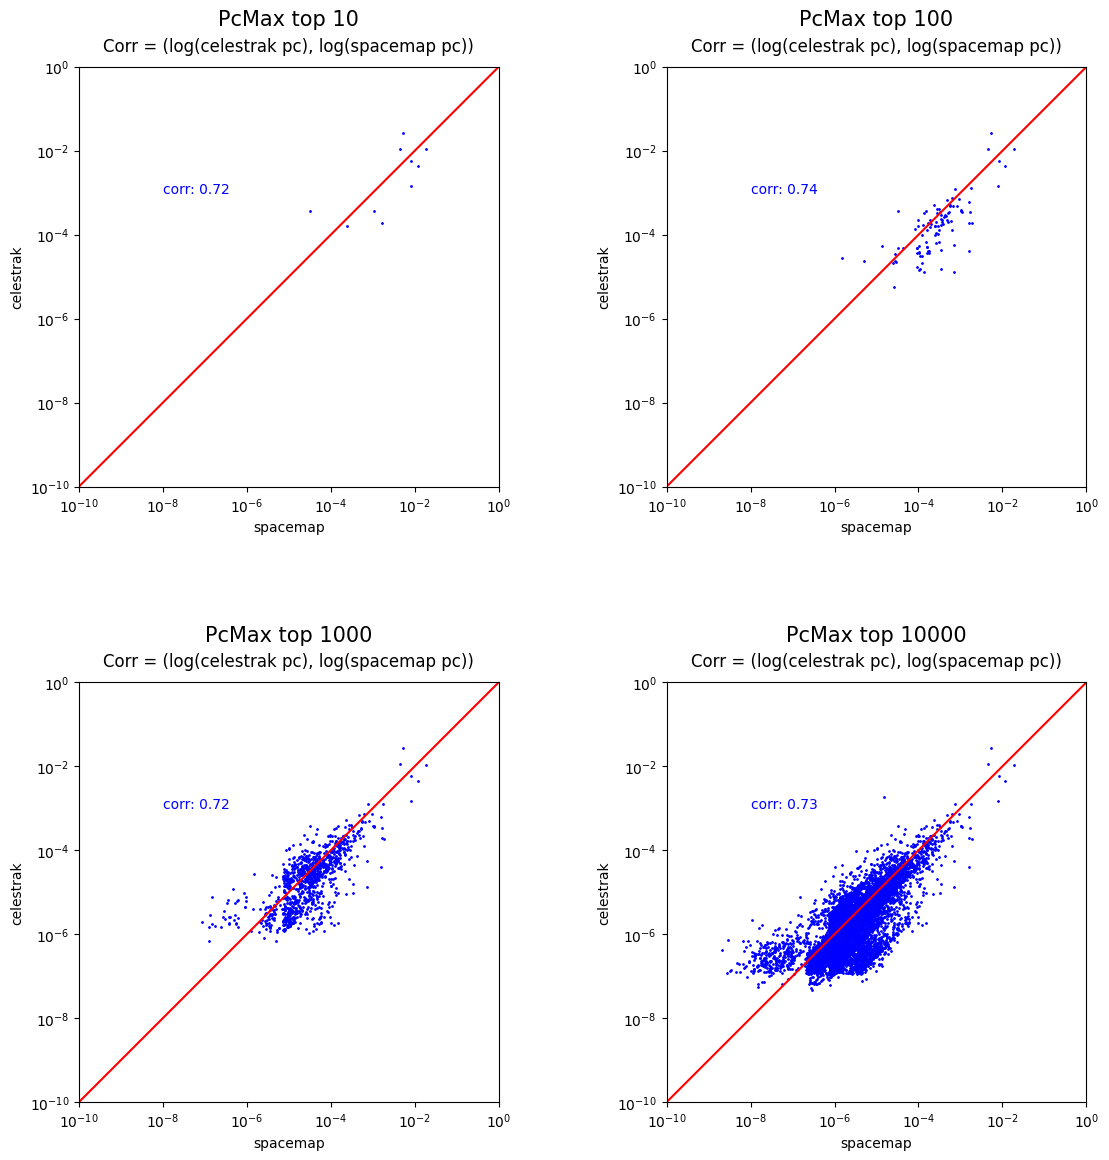

In [8]:
output = pd.read_csv('./result/output_10m24d08h.csv')
output = output[1::2]
output_sorted = output.sort_values(by='TCA_RANGE')
splitted_output_list = [output_sorted[:10], output_sorted[:100], output_sorted[:1000], output_sorted[:10000]]

titles = ["PcMax top 10", "PcMax top 100", "PcMax top 1000", "PcMax top 10000"]

fig, axes = plt.subplots(2, 2, figsize=(13, 13))

# Create a loop to iterate through both data lists
for i in range(len(splitted_output_list)):
    correlation = np.log10(splitted_output_list[i]['PC_ALFANO']).corr(np.log10(splitted_output_list[i]['PC_CELESTRAK']))
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    ax.scatter(splitted_output_list[i]['PC_ALFANO'], splitted_output_list[i]['PC_CELESTRAK'], s=1, label=f"sorted_data{i+1}", color='b')
    ax.set_title(titles[i], pad=30, fontsize=15)
    ax.set_xlabel('spacemap')
    ax.set_ylabel('celestrak')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-10, 1e-0)
    ax.set_ylim(1e-10, 1e-0)
    ax.text(1E-08, 1E-03, f'corr: {round(correlation, 2)}', fontsize=10, color='b')

    text = 'Corr = (log(celestrak pc), log(spacemap pc))'
    ax.text(0.5, 1.05, text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    x = np.linspace(0, 10, 100)  # 0에서 10까지 100개의 점으로 나눈 범위

    ax.plot(x, x, color='red')
    ax.set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.45)
plt.show()